In [1]:
import numpy as np
from StringIO import StringIO
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import urllib2,base64
import cPickle as pickle
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy as sp
import gdal,ogr
from gdalconst import * 
import datetime
import math
import operator
import re
import os
import os.path
import requests, time
import urllib, json
import csv
import seaborn as sns; sns.set()
import glob
import newlinejson as nlj
from calendar import monthrange
import netCDF4
from netCDF4 import Dataset
import xarray as xr
import dask as ds
from dask import dataframe as dd 
%matplotlib inline

### 1. Extract tweet records

In [35]:
#year="2014"
years=["2013","2014","2015","2016"]
tweets="ALL"
retweets="RT"

In [36]:
df_list=list()
df_relist=list()
for year in years:
    path_to_tweets = "ALL-cities/" + tweets+"-cities-"+year
    json_files = [pos_json for pos_json in os.listdir(path_to_tweets) if pos_json.endswith('.json')]

    # we need both the json and an index number so use enumerate()
    for index, js in enumerate(json_files):    
        data=pd.read_json(os.path.join(path_to_tweets, js), lines=True)
        df_list.append(data)

    ##############################################################################################################################

    path_to_retweets = "RT-cities/" + retweets+"-cities-"+year

    json_files = [pos_json for pos_json in os.listdir(path_to_retweets) if pos_json.endswith('.json')]

    # we need both the json and an index number so use enumerate()
    for index, js in enumerate(json_files):    
        data=pd.read_json(os.path.join(path_to_retweets, js), lines=True)
        df_relist.append(data)

cities_df = pd.concat(df_list)
cities_df = cities_df.sort_values(by=['lat', 'timestamp']).reset_index(drop=True)

cities_re_df = pd.concat(df_relist)
cities_re_df = cities_re_df.sort_values(by=['lat', 'timestamp']).reset_index(drop=True)

cities_df = pd.merge(cities_df, cities_re_df, on=['lat','lon','timestamp'],suffixes=('_tweet', '_retweet'))
cities_df = cities_df.drop_duplicates(['lat','lon','timestamp'])
cities_df['ratio']=cities_df['count_retweet']/cities_df['count_tweet']

cities_df['idx'] = pd.Categorical(cities_df['lat'].astype(str) + '_' + cities_df['lon'].astype(str)).codes

#add "month","year" to each entry
cities_df.timestamp = cities_df.timestamp.astype(str)
cities_df['timestamp']=pd.to_datetime(cities_df['timestamp'], errors='coerce')
cities_df['month']=cities_df['timestamp'].dt.month
cities_df['year']=cities_df['timestamp'].dt.year

In [37]:
### demean month average from each record
cities_grouped_df=cities_df.groupby([cities_df.idx,cities_df.month,cities_df.year])['count_tweet'].sum().to_frame().reset_index()
cities_regrouped_df=cities_df.groupby([cities_df.idx,cities_df.month,cities_df.year])['count_retweet'].sum().to_frame().reset_index()
cities_grouped_df = pd.merge(cities_grouped_df, cities_regrouped_df, on=['idx','month','year'])

mean_tweet_list=cities_grouped_df.apply(lambda row: row['count_tweet'] / monthrange(row.year,int(row.month))[1], axis=1)
mean_retweet_list=cities_grouped_df.apply(lambda row: row['count_retweet'] / monthrange(row.year,int(row.month))[1], axis=1)

cities_grouped_df['mean_tweet'] = mean_tweet_list
cities_grouped_df['remean_tweet'] = mean_retweet_list
#cities_grouped_df['mean_tweet'] = cities_grouped_df.apply(lambda row: row['count_tweet'] / monthrange(row.year,int(row.month))[1], axis=1)
#cities_grouped_df['mean_retweet'] = cities_grouped_df.apply(lambda row: row['count_retweet'] / monthrange(row.year,int(row.month))[1], axis=1)

cities_df = pd.merge(cities_df, cities_grouped_df.drop(columns=['count_tweet', 'count_retweet']), on=['idx', 'month','year'], how='left')

cities_df = cities_df.rename(columns={'lat': 'LAT', 'lon': 'LON'})

In [38]:
cities_df.head(34)

,count_tweet,LAT,loc_tweet,LON,timestamp,count_retweet,loc_retweet,ratio,idx,month,year,mean_tweet,remean_tweet
0,24102,29.4241,"San Antonio, TX",-98.4936,2013-01-01,6385,San Antonio,0.264916,0,1,2013,24492.935484,6343.903226
1,26584,29.4241,San Antonio,-98.4936,2013-01-02,7140,San Antonio,0.268583,0,1,2013,24492.935484,6343.903226
2,28378,29.4241,San antonio de areco,-98.4936,2013-01-03,7338,San Antonio,0.258581,0,1,2013,24492.935484,6343.903226
3,28787,29.4241,"San Antonio, Tx",-98.4936,2013-01-04,7428,San Antonio de los Altos,0.258033,0,1,2013,24492.935484,6343.903226
4,26146,29.4241,Gallatin TN / San Antonio,-98.4936,2013-01-05,6793,San Antonio de Los Altos,0.259810,0,1,2013,24492.935484,6343.903226
5,25347,29.4241,San Antonio,-98.4936,2013-01-06,6558,"San Antonio, Tx",0.258729,0,1,2013,24492.935484,6343.903226
6,26454,29.4241,"San Antonio (Converse), Texas",-98.4936,2013-01-07,7020,San Antonio de Los Altos,0.265366,0,1,2013,24492.935484,6343.903226
7,27142,29.4241,"San Antonio, Texas",-98.4936,2013-01-08,7293,Villaverde de Medina,0.268698,0,1,2013,24492.935484,6343.903226
8,26106,29.4241,San Antonio,-98.4936,2013-01-09,6689,San Antonio,0.256225,0,1,2013,24492.935484,6343.903226
9,25537,29.4241,San Antonio :),-98.4936,2013-01-10,6545,"san antonio , tx",0.256295,0,1,2013,24492.935484,6343.903226


In [39]:
cities_centers=dict()
cities_centers['new york']=(40.7128,-74.0060)
cities_centers['los angeles']=(34.0522,-118.2437)
cities_centers['chicago']=(41.8781,-87.6298)
cities_centers['houston']=(29.7604, -95.3698)
cities_centers['phoenix']=(33.4484,-112.0740)
cities_centers['philadelphia']=(39.9526,-75.1652)
cities_centers['san antonio']=(29.4241, -98.4936)
cities_centers['san diego']=(32.7157, -117.1611)
cities_centers['dallas']=(32.7767, -96.7970)
cities_centers['san jose']=(37.3382, -121.8863)
cities_centers['austin']=(30.2672,-97.7431)
cities_centers['jacksonville']=(30.3322,-81.6557)
cities_centers['san francisco']=(37.7749,-122.4194)
cities_centers['columbus']=(39.9612,-82.9988)
cities_centers['fort worth']=(32.7555, -97.3308)
cities_centers['indianapolis']=(39.7684, -86.1581)
cities_centers['charlotte']=(35.2271,-80.8431)
cities_centers['seattle']=(47.6062, -122.3321)
cities_centers['denver']=(39.7392, -104.9903)
cities_centers['washington d.c.']=(38.9072, -77.0369)
cities_centers['boston']=(42.3601,-71.0589)


### 2. Attach weather data to each tweet record

In [41]:
def getWeatherNormalPRIMS(locs_df, img): ####USed for TMAX/TMIN/PRCP
    band = img.GetRasterBand(1)
    nodatavalue = band.GetNoDataValue()
    ncol = img.RasterXSize
    nrow = img.RasterYSize
    geotransform = img.GetGeoTransform()
    originX = geotransform[0]
    b=geotransform[2]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    d=geotransform[4]
    pixelHeight = geotransform[5]
    data = band.ReadAsArray()
    data[data == nodatavalue] = np.nan
    data_ind_array= np.argwhere(~np.isnan(data)).astype(float)
    
    points_list = np.array(zip(locs_df.LAT, locs_df.LON)) #list of X,Y coordinates
    values_list=list()
    for point in points_list:
        row = int((point[0] - originY) / pixelHeight)
        col = int((point[1] - originX) / pixelWidth)
        #print point[0],point[1], row,col, data[row][col]
        values_list.append(data[row][col])
        
    return np.array(values_list)

############################################################################################################################################


def getWeatherNormalNCEP(locs_df,Dataset, M, i): ##HUM/CC/WIND   datafram [LAT,LON] ; Dataset; Metrics; Date
    
    date_index =i
    
    #topoin,lons = shiftgrid(180.,topoin,Dataset.variables['lon'][:],start=False)
    #lat_idx = np.abs(lats - darwin['lat']).argmin()
    #lon_idx = np.abs(lons - darwin['lon']).argmin()
    data_list=list()
    if M=="HUM":
        rhum_var = Dataset.variables['rhum'][:]
        #rhum_var[rhum_var==-32767]=np.nan
        #rhum_var,lons = shiftgrid(180.,rhum_var,Dataset.variables['lon'][:],start=False)
        #rhum_var = Dataset.variables['rhum'][date_index,0,41.87,-87.62]
        lats=Dataset.variables['lat'][:]
        lons=Dataset.variables['lon'][:]
        for index, row in locs_df.iterrows():          
            lat_idx = np.abs(lats - row['LAT']).argmin()
            lon_idx = np.abs(lons - (row['LON'] % 360)).argmin()
            #print date_index[0],lat_idx,lon_idx
            rhum_var = Dataset.variables['rhum'][date_index,0,lat_idx,lon_idx]
            data_list.append(rhum_var)
            
    if M=="CC":
        tcdc_var = Dataset.variables['tcdc'][:]
        #tcdc_var[tcdc_var==-32767]=np.nan
        #tcdc_var,lons = shiftgrid(180.,tcdc_var,Dataset.variables['lon'][:],start=False)
        lats=Dataset.variables['lat'][:]
        lons=Dataset.variables['lon'][:]
        for index, row in locs_df[['LAT','LON']].iterrows():          
            lat_idx = np.abs(lats - row['LAT']).argmin()
            lon_idx = np.abs(lons - (row['LON'] % 360)).argmin() 
            tcdc_var = Dataset.variables['tcdc'][date_index,lat_idx,lon_idx]
            data_list.append(tcdc_var)
    
    if M=="WIND":
        uwind_var = Dataset['uwnd'].variables['uwnd'][:]
        vwind_var = Dataset['vwnd'].variables['vwnd'][:]
        #uwind_var[uwind_var==-32767]=np.nan
        #vwind_var[vwind_var==-32767]=np.nan
        #uwind_var,uwind_lons = shiftgrid(180.,uwind_var,Dataset['uwnd'].variables['lon'][:],start=False)
        #vwind_var,vwind_lons = shiftgrid(180.,vwind_var,Dataset['vwnd'].variables['lon'][:],start=False)
        uwind_lats=Dataset['uwnd'].variables['lat'][:]
        vwind_lats=Dataset['vwnd'].variables['lat'][:]
        uwind_lons=Dataset['uwnd'].variables['lon'][:]
        vwind_lons=Dataset['vwnd'].variables['lon'][:]
        for index, row in locs_df[['LAT','LON']].iterrows():          
            ulat_idx = np.abs(uwind_lats - row['LAT']).argmin()
            ulon_idx = np.abs(uwind_lons - (row['LON'] % 360)).argmin() 
            vlat_idx = np.abs(vwind_lats - row['LAT']).argmin()
            vlon_idx = np.abs(vwind_lons - (row['LON'] % 360)).argmin() 
            
            uwind_var = Dataset['uwnd'].variables['uwnd'][date_index,0,ulat_idx,ulon_idx]
            vwind_var = Dataset['vwnd'].variables['vwnd'][date_index,0,vlat_idx,vlon_idx]
            
            wind_var=math.sqrt(math.pow(uwind_var,2)+ math.pow(vwind_var,2))
            data_list.append(wind_var)
    #print lons
    #index=netCDF4.date2num(dt,Dataset.variables['time'].units)
    return np.array(data_list)

def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print "\t\ttype:", repr(nc_fid.variables[key].dtype)
            for ncattr in nc_fid.variables[key].ncattrs():
                print '\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr))
        except KeyError:
            print "\t\tWARNING: %s does not contain variable attributes" % key

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print "NetCDF Global Attributes:"
        for nc_attr in nc_attrs:
            print '\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print "NetCDF dimension information:"
        for dim in nc_dims:
            print "\tName:", dim 
            print "\t\tsize:", len(nc_fid.dimensions[dim])
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print "NetCDF variable information:"
        for var in nc_vars:
            if var not in nc_dims:
                print '\tName:', var
                print "\t\tdimensions:", nc_fid.variables[var].dimensions
                print "\t\tsize:", nc_fid.variables[var].size
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [42]:
cities_df.timestamp = cities_df.timestamp.dt.strftime("%Y%m%d").astype(str)
cities_df = cities_df.sort_values(by=['timestamp','idx']).reset_index(drop=True)

In [43]:
for norm in ['TMAX','TMIN','PRCP']:  
    weather_list=list()
    for year in ['2013','2014','2015','2016']:
        date_range=np.array([d.strftime('%Y%m%d') for d in pd.date_range(year+'0101',year+'1231')])
        for yearly_date in date_range:
            if norm=="PRCP":
                filename=r'/vsizip/data/PRISM/PRISM_'+"PPT".lower()+'_stable_4kmD2_'+year+'0101_'+year+'1231_bil.zip/PRISM_'+"PPT".lower()+'_stable_4kmD2_'+yearly_date+'_bil.bil'
            else:
                filename=r'/vsizip/data/PRISM/PRISM_'+norm.lower()+'_stable_4kmD1_'+year+'0101_'+year+'1231_bil.zip/PRISM_'+norm.lower()+'_stable_4kmD1_'+yearly_date+'_bil.bil'
            gdal.GetDriverByName('EHdr').Register()
            img = gdal.Open(filename, GA_ReadOnly)
            norm_list=getWeatherNormalPRIMS(cities_df[cities_df['timestamp']==yearly_date],img)
            weather_list.extend(norm_list)   
        print "Get all reads for USA "+year+ ", "+ norm
       
    
    cities_df[norm]=weather_list

Get all reads for USA 2013, TMAX
Get all reads for USA 2014, TMAX
Get all reads for USA 2015, TMAX
Get all reads for USA 2016, TMAX
Get all reads for USA 2013, TMIN
Get all reads for USA 2014, TMIN
Get all reads for USA 2015, TMIN
Get all reads for USA 2016, TMIN
Get all reads for USA 2013, PRCP
Get all reads for USA 2014, PRCP
Get all reads for USA 2015, PRCP
Get all reads for USA 2016, PRCP


In [44]:
for norm in ['HUM','CC','WIND']:
    weather_list=list()
    for year in ['2013','2014','2015','2016']:
        start_date=year+'0101'
        end_date=year+'1231'
        hum_year=Dataset('data/NCEP/rhum.'+year+'.nc')
        #nc_attrs, nc_dims, nc_vars = ncdump(hum_year)

        #print "********************************************************* SPLIT ****************************************************************"
        cc_year=Dataset('data/NCEP/tcdc.eatm.gauss.'+year+'.nc')
        #nc_attrs, nc_dims, nc_vars = ncdump(cc_year)
        #print "********************************************************* SPLIT ****************************************************************"
        vw_year=Dataset('data/NCEP/vwnd.10m.gauss.'+year+'.nc')
        uw_year=Dataset('data/NCEP/uwnd.10m.gauss.'+year+'.nc')
        wind_year=dict()
        wind_year['uwnd']=uw_year
        wind_year['vwnd']=vw_year
        #nc_attrs, nc_dims, nc_vars = ncdump(vw_year)
        #nc_attrs, nc_dims, nc_vars = ncdump(uw_year)

        data_year_dict=dict()
        data_year_dict['HUM']=hum_year
        data_year_dict['CC']=cc_year
        data_year_dict['WIND']=wind_year

        date_range=np.array([d.strftime('%Y%m%d') for d in pd.date_range(start_date,end_date)])
        i=0
        for date in date_range:
            weather_list.extend(getWeatherNormalNCEP(cities_df[cities_df['timestamp']==date],data_year_dict[norm], norm,i))
            i=i+1
        
        print "Get all reads for USA "+year+ ", "+ norm
        
    cities_df[norm]=weather_list

Get all reads for USA 2013, HUM
Get all reads for USA 2014, HUM
Get all reads for USA 2015, HUM
Get all reads for USA 2016, HUM
Get all reads for USA 2013, CC
Get all reads for USA 2014, CC
Get all reads for USA 2015, CC
Get all reads for USA 2016, CC
Get all reads for USA 2013, WIND
Get all reads for USA 2014, WIND
Get all reads for USA 2015, WIND
Get all reads for USA 2016, WIND


In [48]:
cities_df['nratio']=cities_df['ratio'] - cities_df['remean_tweet']/cities_df['mean_tweet']

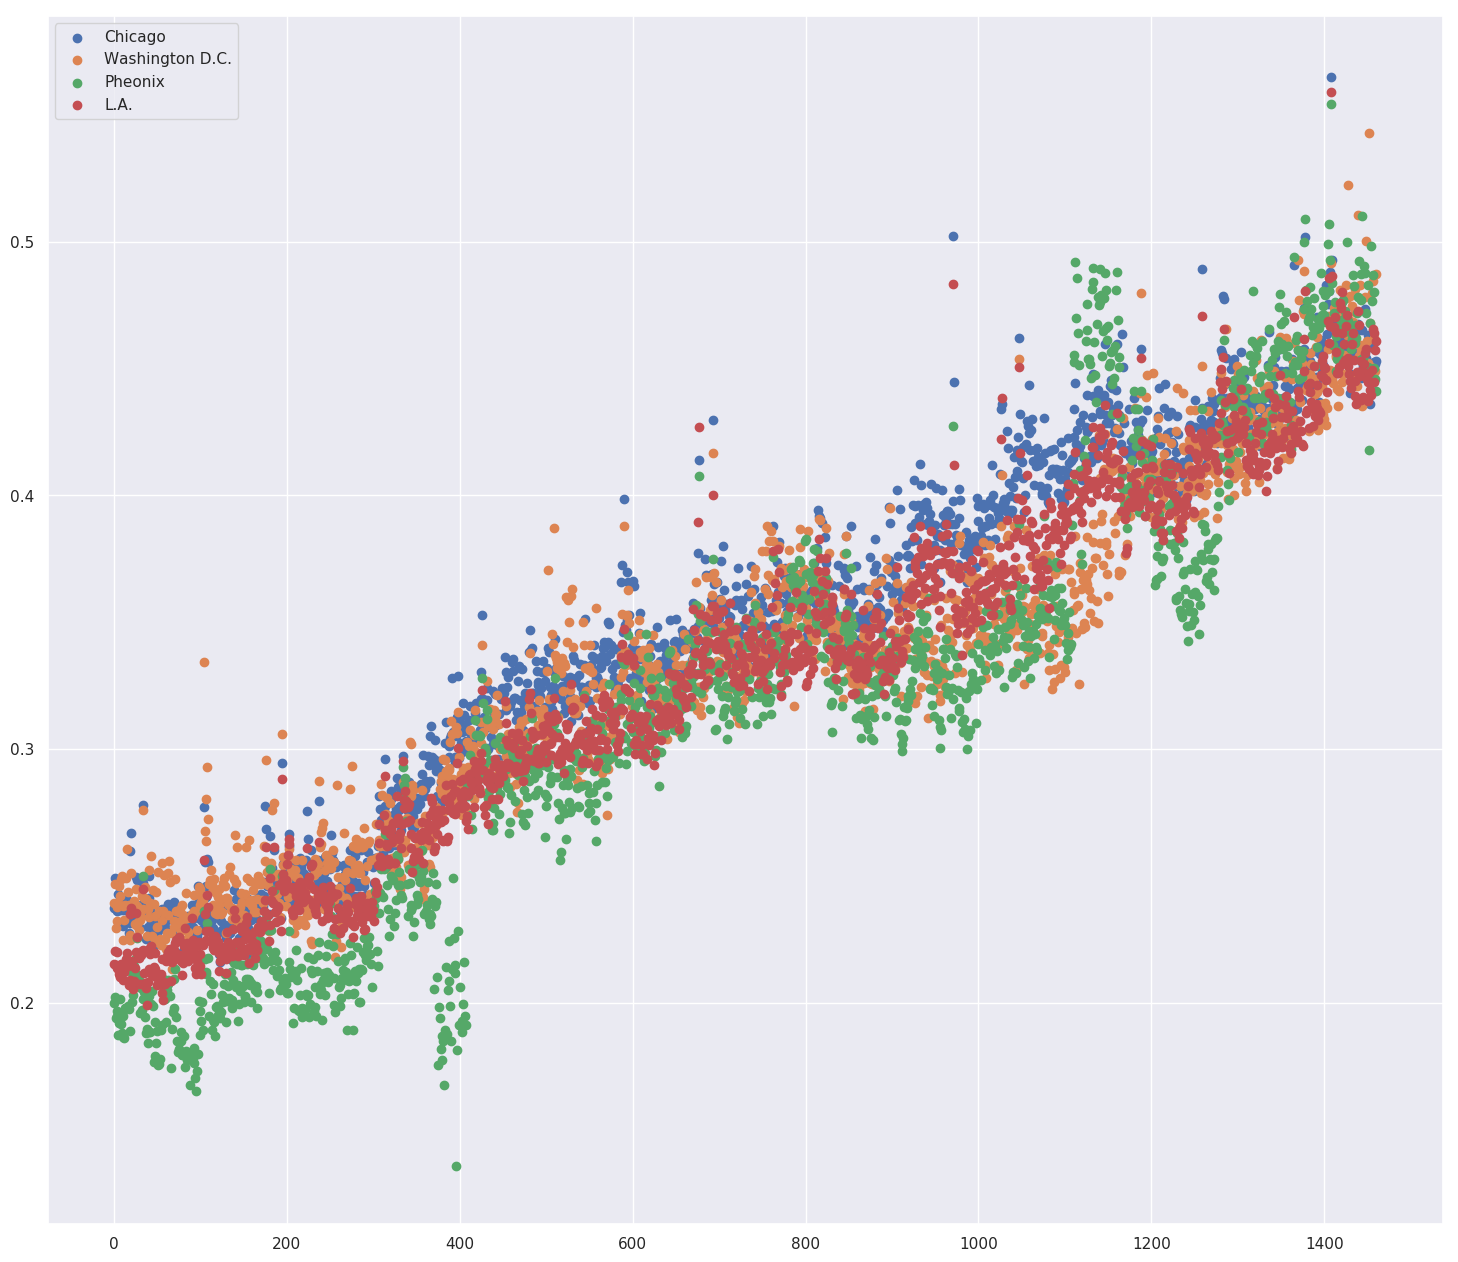

In [26]:
from matplotlib.pyplot import figure
feature="ratio"
figure(num=None, figsize=(18, 16), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(range(1461), cities_df[(cities_df['idx']==18)][feature], label="Chicago")
plt.scatter(range(1461), cities_df[(cities_df['idx']==12)][feature], label="Washington D.C.")
plt.scatter(range(1461), cities_df[(cities_df['idx']==7)][feature], label="Pheonix")
plt.scatter(range(1461), cities_df[(cities_df['idx']==8)][feature], label="L.A.")
plt.legend()

In [25]:
cities_df.groupby(['idx'])['TMAX'].mean()

21.393004010123914

In [49]:
cities_df.to_csv('data/US20_integrated.csv',encoding='utf-8') 

In [10]:
cities_df=pd.read_csv('data/US20_integrated.csv',encoding='utf-8',index_col=0) ####### these two lines do not have practical purpose
cities_df.head(21)

,count_tweet,LAT,loc_tweet,LON,timestamp,count_retweet,loc_retweet,ratio,idx,month,year,mean_tweet,remean_tweet,TMAX,TMIN,PRCP,HUM,CC,WIND,nratio
0,24102,29.4241,"San Antonio, TX",-98.4936,20130101,6385,San Antonio,0.264916,0,1,2013,24492.935484,6343.903226,16.700001,10.17,5.22,93.740005,85.099854,6.194274,0.005906
1,61507,29.7604,"Houston , Texas.",-95.3698,20130101,15419,houston texas,0.250687,1,1,2013,63406.322581,15487.935484,20.059999,12.04,26.57,99.990005,98.500000,4.993804,0.006422
2,25006,30.2672,"Austin, TX",-97.7431,20130101,6152,"Austin, Tx",0.246021,2,1,2013,26392.451613,6247.387097,13.930000,6.86,5.30,93.740005,90.599854,6.340384,0.009310
3,12471,30.3322,"Jacksonville, AL",-81.6557,20130101,3017,"Jacksonville, IL",0.241921,3,1,2013,12072.709677,2879.129032,18.620001,5.13,0.00,81.740005,47.899902,3.413755,0.003439
4,21747,32.7157,"San Diego, CA",-117.1611,20130101,4733,"San Diego, CA",0.217639,4,1,2013,23559.064516,4952.322581,15.050000,4.59,0.00,61.500000,49.800049,3.842520,0.007430
5,8021,32.7555,"Wise, VA",-97.3308,20130101,2115,Fort Worthh,0.263683,5,1,2013,8371.258065,2057.774194,9.820000,3.71,4.28,86.990005,42.399902,4.920614,0.017869
6,44951,32.7767,"Fort Collins, Colorado",-96.7970,20130101,10898,dallas/abilene texas,0.242442,6,1,2013,47047.741935,11135.612903,8.750000,4.23,6.62,86.990005,42.399902,4.920614,0.005754
7,10763,33.4484,IG:PhoenixBlows__,-112.0740,20130101,2153,"Denver, CO/ Phoenix, AZ",0.200037,7,1,2013,11826.419355,2368.322581,12.630000,2.32,0.00,61.250000,19.599854,3.630721,-0.000220
8,89425,34.0522,"Victoяia †, Los Angeles, CA",-118.2437,20130101,19248,"Los Angeles, California",0.215242,8,1,2013,91328.580645,19749.387097,15.410000,3.93,0.00,66.990005,63.699951,4.442998,-0.001004
9,18168,35.2271,"Charlotte, NC",-80.8431,20130101,4237,Charlotte,0.233212,9,1,2013,18626.193548,4353.354839,11.750000,-1.15,0.00,74.990005,84.899902,2.715436,-0.000510
